In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from scipy.optimize import curve_fit 
import emcee
import corner

clight = 299792.458 # speed of light in km/s``

/Users/conor/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/conor/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# analysis parameters to be varied
sample = "with94D"  # sample cuts to make (see below)

# these will stay fixed
pecvel_unc = 150.0   # peculiar velocity uncertainty in km/s
one_over_sigma_prior = False # set Pr(sigma) ~ 1/sigma, else uniform > 0

In [3]:
# cuts list:          zerr_max, z_min, x1_min, x1_max, c_min, c_max, loghostmass_min, gz_min, ztf_correct, distmode, ndim
samples = { "fiducial":   ( 0.001, 0.023, -2.0,  0.0, -0.2, 0.1, 10.0,  1.0, True,  "dynamic"  , 6 ), 
            "allcalib":   ( 0.001, 0.023, -2.2,  0.0, -0.2, 0.1, 10.0,  1.0, True,  "dynamic"  , 6 ), 
            "strict":     ( 0.001, 0.023, -2.0, -1.0, -0.1, 0.0, 10.0,  1.0, True,  "dynamic"  , 6 ),
            "all":        ( 0.100, 0.000, -3.0,  3.0, -0.3, 1.0,  0.0, -9.9, True,  "dynamic"  , 6 ),
            "loose":      ( 0.005, 0.015, -3.0,  1.0, -0.3, 0.5, 10.0, -9.9, True,  "dynamic"  , 6 ),
            "noztfcorr":  ( 0.001, 0.023, -2.0,  0.0, -0.2, 0.1, 10.0,  1.0, False, "dynamic"  , 6 ),
            "kinematic":  ( 0.001, 0.023, -2.0,  0.0, -0.2, 0.1, 10.0,  1.0, True,  "kinematic", 6 ),
            "nohostmass": ( 0.001, 0.023, -2.0,  0.0, -0.2, 0.1, 10.0,  1.0, True,  "dynamic"  , 5 ),
            "with94D":    ( 0.001, 0.023, -2.0,  0.0, -0.2, 0.1, 10.0,  1.0, True,  "dynamic"  , 6 ),
            "calibsigma": ( 0.001, 0.023, -2.0,  0.0, -0.2, 0.1, 10.0,  1.0, True,  "dynamic"  , 7 ) # too few calibrators for this
          }
zerr_max, z_min, x1_min, x1_max, c_min, c_max, loghostmass_min, gz_min, ztf_correct, distmode, ndim = samples.get(sample)
print(zerr_max, z_min, x1_min, x1_max, c_min, c_max, loghostmass_min, gz_min)

calib_outliers = [None]

# outliers in ZTF data set to remove
hflow_outliers = ['2018ccl','2019etc','2020nef','2020pwn','2020sii','2020acua','2020adii']
# hflow_outliers = [None]

0.001 0.023 -2.0 0.0 -0.2 0.1 10.0 1.0


In [4]:
if sample == "with94D":
    calib_datafile = "trgb_calibrators_cov_with94D.csv"
else:   
    calib_datafile = "trgb_calibrators_cov.csv"

hflow_datafile = "ztf_data_hd.csv"

In [5]:
# output plots will start with this prefix
pdf_basename = "output/H0-" + sample

print(pdf_basename)

output/H0-with94D


In [6]:
# function to convert peculiar velocity uncertainty (km/s) into magnitudes
#    this includes a small "correction factor" that accounts for the nonlinearity in a std LCDM cosmology
#    the correction factor is negligible at low redshift
#       from https://github.com/sdhawan21/irh0/blob/master/full-analysis.ipynb -- better citation would be nice
def pverr2mag(z,pverr,correction=True):

    if correction:
        assert ((np.min(z) >= 0) and (np.max(z) <= 3)),"Correction factor defined for z=0-3 only"
        correction_coeffs = [1.00171318, 0.74494186, -0.97690614, 0.69153719, -0.28044894, 
                             0.06058092, -0.00537420]
        corrfactor = np.polyval(correction_coeffs[::-1],z)
    else:
        corrfactor = 1.0
        
    return 5.0/np.log(10.0)*pverr/clight/z*corrfactor

In [7]:
# function to return distance modulus mu(z) assuming H0=70
#   mode="dynamic" uses flat LCDM cosmology with Om=0.3, Om=0.7 (+ photons,neutrinos)
#   mode="kinematic" uses approximation with q0=-0.55, j0=1
#   negligible difference between these at low redshift
def distmod70(z,mode="dynamic"):
    if mode == "dynamic":
        cosmo = FlatLambdaCDM(H0=70.0, Om0=0.3)
        return 5.0 * np.log10(cosmo.luminosity_distance(z)/u.Mpc) + 25.0
    elif mode == "kinematic":
        q0 = -0.55
        j0 = 1.0
        return 5.0 * np.log10(clight*z/70.0 *
                              (1 + (1 - q0)*z/2.0 
                               - (1 - q0 - 3*q0**2 + j0)*(z**2)/6.0)) + 25.0
    else:
        raise ValueError("Undefined mode")    

In [8]:
# calibrators
calib_all = pd.read_csv(calib_datafile).dropna()
ncalib_all = len(calib_all)

# add columns
calib_all["mB"] = -2.5 * np.log10(calib_all.x0) + 10.5  # SALT3 convention, check this
cmBup = -2.5 * np.log10(calib_all.x0 - calib_all.x0err) + 10.5
cmBdn = -2.5 * np.log10(calib_all.x0 + calib_all.x0err) + 10.5
calib_all["mB_err"] = (cmBup - cmBdn)/2.0 

calib_all["cal_MB"] = calib_all.mB - calib_all.trgb_mu

calib_all["cal_MB_err"] = np.sqrt(calib_all.mB_err**2 + calib_all.trgb_muerr**2)

calib_all["log_hostmass_err"] = 0.15

calib_all['cov_mb_x1'] = -2.5 / np.log(10) / calib_all['x0'] * calib_all['cov_x0_x1']
calib_all['cov_mb_c'] = -2.5 / np.log(10) / calib_all['x0'] * calib_all['cov_x0_c']


# remove outliers:
calib_readin = calib_all.loc[~calib_all['SN'].isin(calib_outliers)]

# apply sample cuts
cgood = (  (calib_readin.x1 < x1_max) & (calib_readin.x1 >= x1_min) &
           (calib_readin.c < c_max) & (calib_readin.c >= c_min) &
           (calib_readin.log_hostmass >= loghostmass_min) ) 
calib = calib_readin[cgood].copy()
ncalib = len(calib)


calib

,SN,x0,x0err,x1,x1err,c,cerr,cov_x0_x1,cov_x0_c,cov_x1_c,...,host_name,log_hostmass,log_sSFR,mB,mB_err,cal_MB,cal_MB_err,log_hostmass_err,cov_mb_x1,cov_mb_c
0,SN 1992A,0.1681,0.0045,-1.600,0.040,-0.028,0.025,0.000015,-0.000098,-0.000140,...,NGC 1380,10.88,-11.55,12.436081,0.029072,-18.883919,0.049449,0.15,-0.000097,0.000633
1,SN 1994D,0.3299,0.0089,-1.558,0.026,-0.099,0.025,0.000034,-0.000200,-0.000150,...,NGC 4526,10.86,-11.29,11.704044,0.029298,-19.295956,0.075884,0.15,-0.000112,0.000658
2,SN 2006dd,0.2122,0.0059,-0.475,0.053,-0.014,0.027,-0.000004,-0.000140,-0.000200,...,NGC 1316,11.56,-11.73,12.183137,0.030196,-19.316863,0.067170,0.15,0.000021,0.000716
4,SN 2011iv,0.1823,0.0038,-1.745,0.033,-0.024,0.021,0.000008,-0.000067,-0.000100,...,NGC 1404,10.96,-12.44,12.348033,0.022635,-18.881967,0.092803,0.15,-0.000048,0.000399
5,SN 2020ue,0.2458,0.0050,-1.839,0.031,-0.025,0.019,0.000006,-0.000084,-0.000082,...,NGC 4636,10.98,-11.34,12.023545,0.022089,-19.096455,0.073402,0.15,-0.000028,0.000371
6,SN 2020nvb,0.2207,0.0053,-1.419,0.065,-0.055,0.024,-0.000120,-0.000100,0.000140,...,NGC 4457,10.49,-11.06,12.140494,0.026078,-18.979506,0.047750,0.15,0.000590,0.000492


In [9]:
## Hubble flow objects
hflow_all = pd.read_csv(hflow_datafile).dropna()
nhflow_all = len(hflow_all)

hflow_all["mB"] = -2.5 * np.log10(hflow_all.x0) + 10.5  # SALT3 convention, check this
hmBup = -2.5 * np.log10(hflow_all.x0 - hflow_all.x0_err) + 10.5
hmBdn = -2.5 * np.log10(hflow_all.x0 + hflow_all.x0_err) + 10.5
hflow_all["mB_err"] = (hmBup - hmBdn)/2.0 

hflow_all['cov_mb_x1'] = -2.5 / np.log(10) / hflow_all['x0'] * hflow_all['cov_x0_x1']
hflow_all['cov_mb_c'] = -2.5 / np.log(10) / hflow_all['x0'] * hflow_all['cov_x0_c']

# ZTF photometry corrections
if ztf_correct:
    prenov2019 = (hflow_all.t0 < 58788.0)
    hflow_all.loc[prenov2019, 'mB'] = hflow_all[prenov2019].mB + 0.024
    hflow_all.loc[prenov2019, 'mB_err'] = np.sqrt(hflow_all[prenov2019].mB_err**2 + 0.035**2) 
    
    postnov2019 = (hflow_all.t0 >= 58788.0)
    # no magnitude correction for post-nov2019 data (pocket effect)
    hflow_all.loc[postnov2019,'mB_err'] = np.sqrt(hflow_all[postnov2019].mB_err**2 + 0.026**2) 
    hflow_all.loc[postnov2019,'x1'] = hflow_all[postnov2019].x1 + 0.14

# cz error is redshift measurement uncertainty plus peculiar velocity uncertainty
hflow_all["cz_err"] = np.sqrt( (clight*hflow_all.redshift_err)**2 + pecvel_unc**2 )
hflow_all["z_err"] = hflow_all.cz_err / clight
# convert z error + peculiar velocity into magnitudes
hflow_all["pv_mag_err"] = pverr2mag(hflow_all.redshift_HD,hflow_all.cz_err)

# for the likelihood function, we pass in the Hubble flow data as the absolute magnitude assuming H0=70
# the best fit H0 is based on the difference between these and the calibrator absolute magnitudes
hflow_all["mu70"] = distmod70(hflow_all.redshift_HD,mode=distmode)
hflow_all["MB70"] = hflow_all.mB - hflow_all.mu70
hflow_all["MB70_err"] = np.sqrt(hflow_all.mB_err**2 + hflow_all.pv_mag_err**2)

# apply sample cuts
hgood = ( (hflow_all.sn_type == 'snia-cosmo') &
          (hflow_all.redshift_err < zerr_max) &
          (hflow_all.redshift_HD > z_min) &  
          (hflow_all.x1 < x1_max) & (hflow_all.x1 >= x1_min) &
          (hflow_all.c < c_max) & (hflow_all.c >= c_min) & 
          (hflow_all.globalmass > loghostmass_min) & 
          (hflow_all.globalrestframe_gz > gz_min) ) 

hflow_cut = hflow_all[hgood].copy()

# remove outliers:
hflow = hflow_cut.loc[~hflow_cut['iau_name'].isin(hflow_outliers)]

nhflow = len(hflow)
hflow

,redshift,redshift_err,source,t0,x0,x1,c,t0_err,x0_err,x1_err,...,mB,mB_err,cov_mb_x1,cov_mb_c,cz_err,z_err,pv_mag_err,mu70,MB70,MB70_err
1,0.029741,0.000011,z_gal,58213.150268,0.005583,-0.711100,-0.148609,0.041382,0.000170,0.037110,...,16.156783,0.048190,-6.210753e-07,0.000804,150.037642,0.000500,0.035969,35.661702,-19.504918,0.060133
9,0.059615,0.000014,z_gal,58911.301139,0.001352,-0.581588,-0.043226,0.138794,0.000043,0.228791,...,17.672529,0.043109,1.798345e-03,0.000823,150.059887,0.000501,0.018814,37.156121,-19.483591,0.047036
17,0.045000,0.000011,z_gal,58434.749625,0.002224,-0.933948,-0.157465,0.133179,0.000071,0.125115,...,17.156240,0.049289,5.241496e-04,0.000907,150.038520,0.000500,0.024251,36.564099,-19.407860,0.054932
23,0.051621,0.000015,z_gal,58244.392093,0.001435,-1.549972,-0.097418,0.139276,0.000051,0.123738,...,17.631506,0.052253,1.135122e-03,0.001062,150.071495,0.000501,0.021720,36.820349,-19.188843,0.056587
27,0.059408,0.000107,z_gal,59023.503977,0.001034,-1.549373,0.027073,0.077849,0.000032,0.117248,...,17.964212,0.042591,2.566203e-04,0.000834,153.404784,0.000512,0.019567,37.115761,-19.151549,0.046871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.059150,0.000013,z_gal,59204.791442,0.000895,-1.241853,0.032377,0.176456,0.000036,0.194903,...,18.120151,0.050714,3.305040e-03,0.001305,150.052825,0.000501,0.018906,37.144523,-19.024372,0.054124
996,0.049086,0.000013,z_gal,59214.554250,0.001810,-0.833203,-0.002932,0.264029,0.000073,0.152129,...,17.355911,0.050939,9.315802e-04,0.001262,150.050543,0.000501,0.022655,36.722018,-19.366107,0.055750
998,0.038640,0.000018,z_gal,59216.014237,0.002129,-1.275696,0.029613,0.363630,0.000081,0.172303,...,17.179662,0.048792,-2.554542e-05,0.001064,150.096174,0.000501,0.028023,36.232006,-19.052345,0.056266
1000,0.058560,0.000016,z_gal,59215.635502,0.001142,-0.943759,0.029319,0.128027,0.000037,0.099394,...,17.856015,0.043727,4.987954e-04,0.000872,150.080064,0.000501,0.019136,37.116521,-19.260506,0.047731


In [10]:
# Define posterior function required by MCMC sampler
# for clarity, we separate out the prior and likelihood

# theta = [H0, M, alpha, beta, sigma_int, gamma (optional), sigma_calib_int (optional)]

# Pr(M, H0) ~ uniform, with H0 > 0
# if one_over_sigma_prior is set: Pr(sigma) ~ 1/sigma so log Pr(sigma) ~ -log(sigma) for sigma > 0
def log_prior(theta):

    nparam = len(theta)
    # return -np.inf if we are out of bounds (H0, sigma, sigma2 <= 0)
    if nparam == 2:
        H0, M = theta
        return 0 if H0 > 0 else -np.inf
    elif nparam == 4:
        H0, M, alpha, beta = theta
        return 0 if H0 > 0 else -np.inf
    elif nparam == 5:
        H0, M, alpha, beta, sigma = theta  # 
        if one_over_sigma_prior:
            return -np.log(sigma) if (H0 > 0 and sigma > 0) else -np.inf 
        else:
            return 0.0 if (H0 > 0 and sigma > 0) else -np.inf 
    elif nparam == 6:
        H0, M, alpha, beta, sigma, gamma = theta  # 
        if one_over_sigma_prior:
            return -np.log(sigma) if (H0 > 0 and sigma > 0) else -np.inf 
        else:
            return 0.0 if (H0 > 0 and sigma > 0) else -np.inf 
    elif nparam == 7:
        H0, M, alpha, beta, sigma, gamma, sigma_calib = theta  # 
        if one_over_sigma_prior:
            return (-np.log(sigma) - np.log(sigma_calib)) if (H0 > 0 and sigma > 0 and sigma_calib > 0) else -np.inf
        else:
            return 0.0 if (H0 > 0 and sigma > 0 and sigma_calib > 0) else -np.inf 
    else:
        raise ValueError("Unexpected size? len(theta) should be 4, 5, 6, or 7")    


# the likelihood is based on how close the calibrators are to the mean absolute magnitude
# and how close the Hubble flow objects are to the mean absolute magnitude for the input H0
def log_likelihood(theta, calib_data, hflow_data):

    nparam = len(theta)

    if nparam == 2:
        H0, M = theta
        alpha = 0.0
        beta = 0.0
        sigma = 0.0
        gamma = 0.0
        sigma_calib = 0.0
    elif nparam == 4:
        H0, M, alpha, beta = theta
        sigma = 0.0
        gamma = 0.0
        sigma_calib = 0.0
    elif nparam == 5:
        H0, M, alpha, beta, sigma = theta  # 
        gamma = 0.0
        sigma_calib = sigma
    elif nparam == 6:
        H0, M, alpha, beta, sigma, gamma = theta  # 
        sigma_calib = sigma
    elif nparam == 7:
        H0, M, alpha, beta, sigma, gamma, sigma_calib = theta  # 
    else:
        raise ValueError("Unexpected size? len(theta) should be 2, 4, 5, 6, or 7")    

    # calibrators 
    calib_absM, calib_absM_err, calib_x1, calib_x1_err, calib_c, calib_c_err, \
        calib_hm, calib_hm_err, calib_covmbx1, calib_covmbc, calib_covx1c = calib_data
    
    calib_vartot = (calib_absM_err**2 + (alpha*calib_x1_err)**2 
                    + (beta*calib_c_err)**2 + (gamma*calib_hm_err)**2 
                    + sigma_calib**2 + 2*alpha*calib_covmbx1 - 2*beta*calib_covmbc 
                    - 2*alpha*beta*calib_covx1c) ### added in covariance uncertainties
    
    
    calib_resid = (calib_absM + alpha*calib_x1 - beta*calib_c + gamma*(calib_hm - 10.0)) - M
    
    calib_loglike = -0.5 * (np.sum( np.log(2 * np.pi * calib_vartot) + (calib_resid**2 / calib_vartot) ))
    
    # Hubble flow
    hflow_absM70, hflow_absM70_err, hflow_x1, hflow_x1_err, hflow_c, hflow_c_err, \
        hflow_hm, hflow_hm_err, hflow_covmbx1, hflow_covmbc, hflow_covx1c = hflow_data

    hflow_vartot = (hflow_absM70_err**2 + (alpha*hflow_x1_err)**2 
                    + (beta*hflow_c_err)**2 + (gamma*hflow_hm_err)**2
                    + sigma**2 + 2*alpha*hflow_covmbx1 - 2*beta*hflow_covmbc 
                    - 2*alpha*beta*hflow_covx1c) ### added in covariance uncertainties
    
    h70mag = 5.0 * np.log10(H0/70.0)
    hflow_resid = (hflow_absM70 + alpha*hflow_x1 - beta*hflow_c + gamma*(hflow_hm - 10.0)) - M + h70mag
    
    hflow_loglike = -0.5 * (np.sum(np.log(2 * np.pi * hflow_vartot) + (hflow_resid**2 / hflow_vartot) ))

    return calib_loglike + hflow_loglike



# posterior = likelihood * prior; we skip computing the likelihood if the prior is zero
def log_posterior(theta, calib_data, hflow_data):
    logpr = log_prior(theta)
    if logpr == -np.inf:
        return logpr
    else:
        return logpr + log_likelihood(theta, calib_data, hflow_data)

In [11]:
# MCMC (emcee) initialization
nwalkers = 200  # number of MCMC walkers
nsteps = 4000  # number of MCMC steps to take
nburn = 3000  # "burn-in" period to let chains stabilize

In [12]:
# create the data arrays
calib_data = (np.asarray(calib.cal_MB), np.asarray(calib.cal_MB_err), 
              np.asarray(calib.x1), np.asarray(calib.x1err), 
              np.asarray(calib.c), np.asarray(calib.cerr), 
              np.asarray(calib.log_hostmass), np.asarray(calib.log_hostmass_err),
              np.asarray(calib.cov_mb_x1), np.asarray(calib.cov_mb_c),
              np.asarray(calib.cov_x1_c) )

hflow_data = (np.asarray(hflow.MB70), np.asarray(hflow.MB70_err), 
              np.asarray(hflow.x1), np.asarray(hflow.x1_err), 
              np.asarray(hflow.c), np.asarray(hflow.c_err), 
              np.asarray(hflow.globalmass), np.asarray(hflow.globalmass_err),
              np.asarray(hflow.cov_mb_x1), np.asarray(hflow.cov_mb_c),
              np.asarray(hflow.cov_x1_c) )               

In [13]:
# set starting guesses based on the data/priors
guess = np.zeros(ndim)
scale = np.ones(ndim)

# first is H0 (km/s/Mpc)
guess[0] = 70.0
scale[0] = 10.0

# second is M (mag)
guess[1] = np.median(calib.cal_MB)  # only use calib data to guess M
scale[1] = 0.3

if ndim >= 3:
    # third is alpha
    guess[2] = 0.15
    scale[2] = 0.05

if ndim >= 4:
    # fourth is beta
    guess[3] = 2.5
    scale[3] = 0.3

if ndim >= 5: # fifth is intrinsic scatter sigma (mag)
    guess[4] = 0.15
    scale[4] = 0.02
    
if ndim >= 6: # sixth is gamma
    guess[5] = 0.0
    scale[5] = 0.2

if ndim >= 7: # seventh is intrinsic scatter for the calibrators
    guess[6] = 0.15
    scale[6] = 0.02

print("guess = ",np.array_str(guess, precision=3, suppress_small=True))
print("scale = ",np.array_str(scale, precision=3, suppress_small=True))

# each walker will start around this point with some Gaussian spread given by scale
starting_guesses = np.random.randn(nwalkers, ndim)*scale + guess
#print(np.array_str(starting_guesses, precision=3, suppress_small=True))

guess =  [ 70.    -19.038   0.15    2.5     0.15    0.   ]
scale =  [10.    0.3   0.05  0.3   0.02  0.2 ]


In [14]:
# Run the MCMC; takes about 20 seconds on my laptop using 6 threads
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, threads=6,
                                args=[calib_data, hflow_data])
%time sampler.run_mcmc(starting_guesses, nsteps, progress=True)
print("done")

100%|███████████████████████████████████████| 4000/4000 [00:59<00:00, 66.76it/s]

CPU times: user 58 s, sys: 552 ms, total: 58.6 s
Wall time: 60 s
done


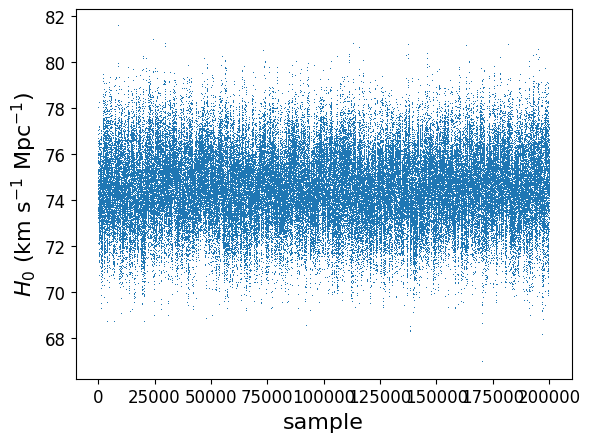

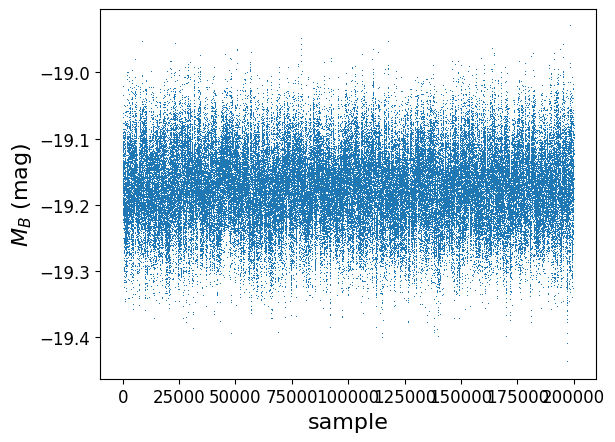

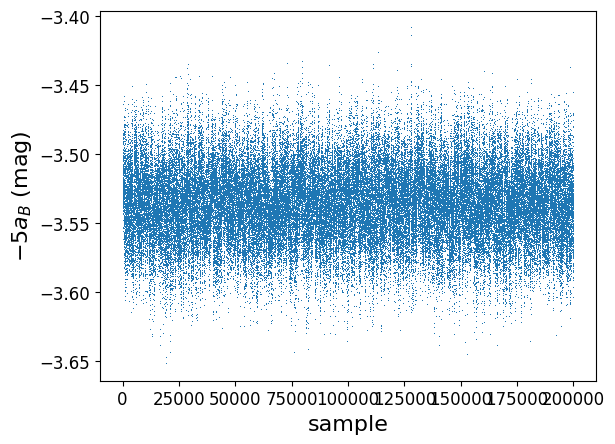

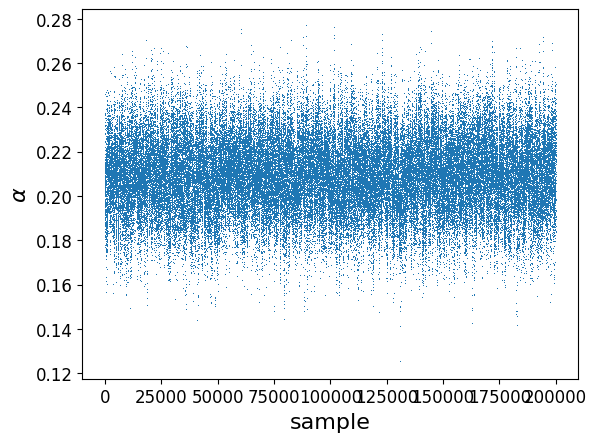

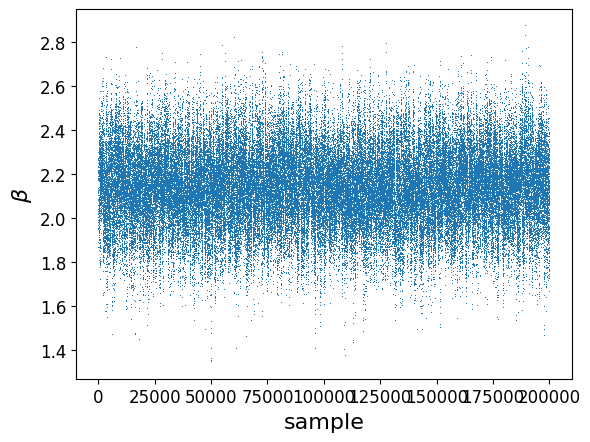

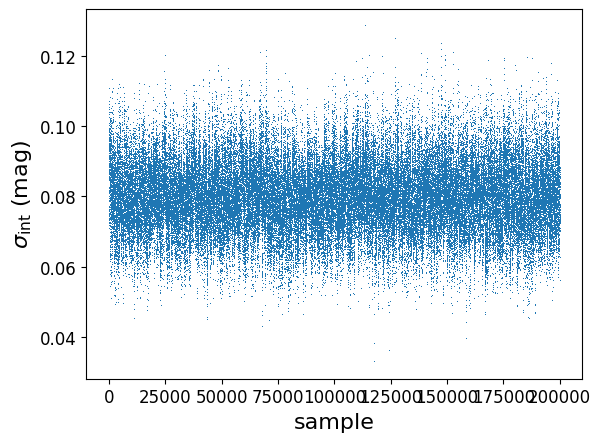

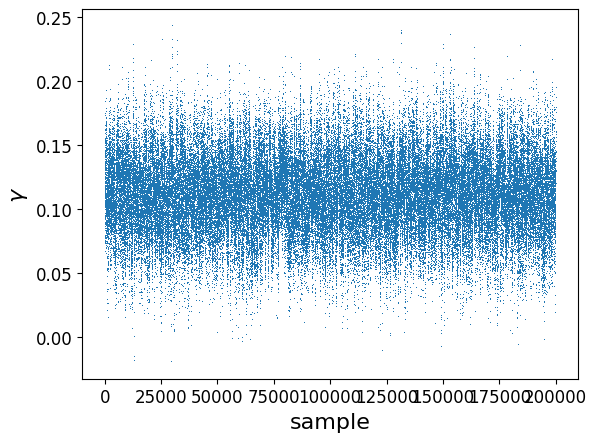

In [15]:
# plot the samples
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

# calculate -5*a_B
ab5m = -5.*np.log10(samples[:,0]) + samples[:,1] + 25
samples = np.insert(samples,2,ab5m,axis=1)


slabels = [r"$H_0$ (km s$^{-1}$ Mpc$^{-1}$)", 
           r"$M_B$ (mag)",
           r"$-5 a_B$ (mag)",
           r"$\alpha$",
           r"$\beta$",
           r"$\sigma_{\mathrm{int}}$ (mag)",
           r"$\gamma$", 
           r"$\sigma_{\mathrm{int, calib}}$ (mag)"]

if ndim == 7: slabels[5] = r"$\sigma_{\mathrm{int, hflow}}$ (mag)"

for i in range(ndim+1):
    plt.plot(samples[:,i],marker=',',linestyle='None')
    plt.xlabel("sample",fontsize=16)
    plt.ylabel(slabels[i],fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

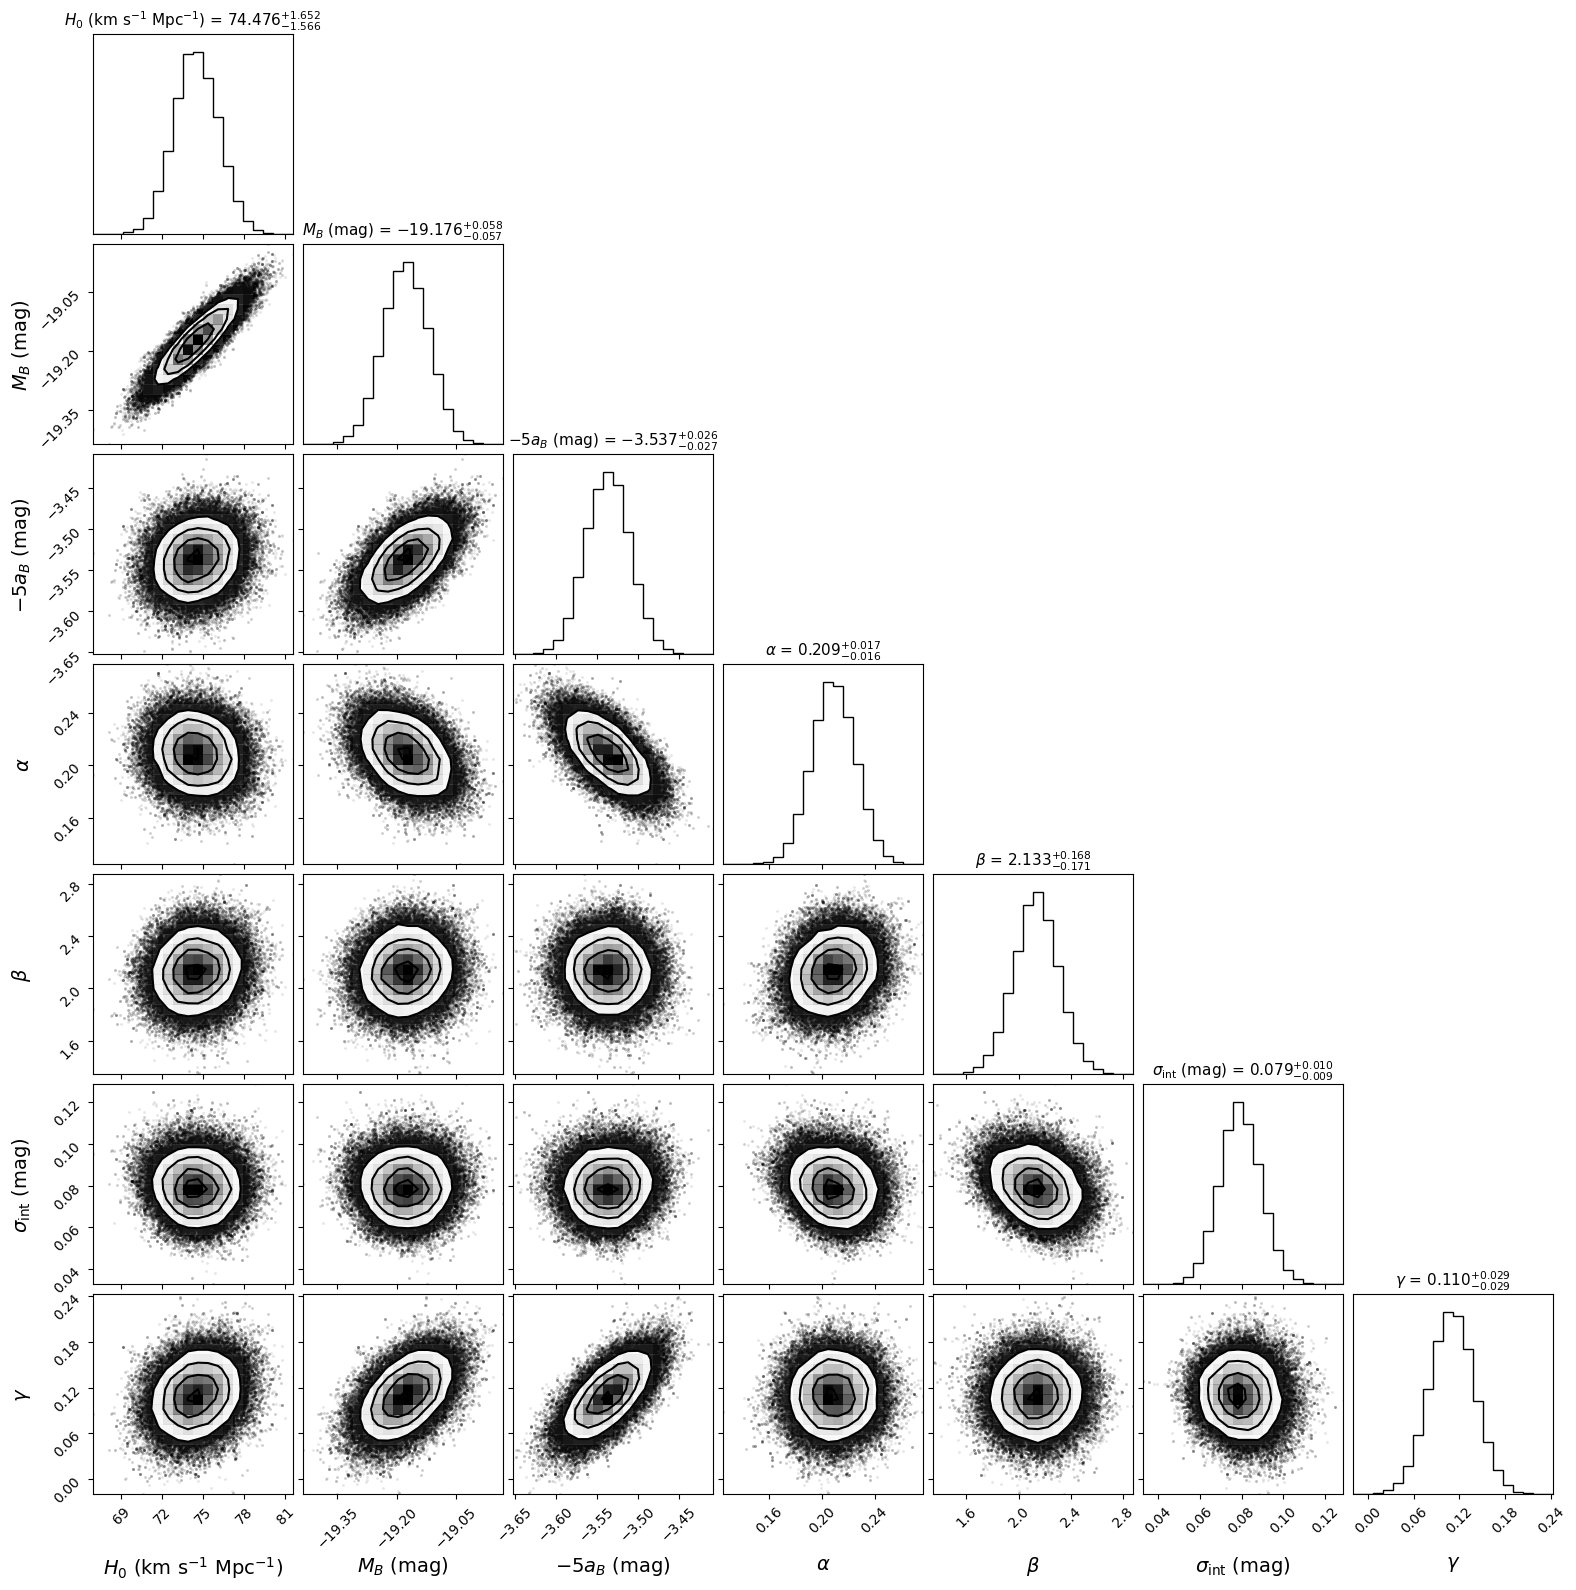

In [16]:
# make corner plot showing parameter distributions and covariances
tlabels = [r"$H_0$ (km s$^{-1}$ Mpc$^{-1}$)", 
           r"$M_B$ (mag)",
           r"$-5 a_B$ (mag)",
           r"$\alpha$",
           r"$\beta$",
           r"$\sigma_{\mathrm{int}}$ (mag)",
           r"$\gamma$", 
           r"$\sigma_{\mathrm{int, calib}}$ (mag)"]

if ndim == 7: slabels[5] = r"$\sigma_{\mathrm{int, hflow}}$ (mag)"

figcorner = corner.corner(samples, labels=tlabels[0:ndim+1], 
                    show_titles=True, title_fmt=".3f", verbose=True,
                    title_kwargs={"fontsize": 11}, label_kwargs={"fontsize": 14})
figcorner.savefig(pdf_basename+"_corner.png",dpi=300,bbox_inches="tight")

In [17]:
# sample means, medians
means = np.mean(samples,axis=0)
sigma = np.std(samples,axis=0)

q = np.percentile(samples,[16,50,84],axis=0)
medians = q[1,:]
minus = q[0,:] - medians
plus = q[2,:] - medians

H0_mean = medians[0]
MB_mean = medians[1]
ab5m_mean = medians[2] 

alpha_mean = 0.0
beta_mean = 0.0
if ndim >= 3:
    alpha_mean = medians[3]
    beta_mean = medians[4]

sigma_hflow_mean = 0.0
sigma_calib_mean = 0.0
gamma_mean = 0.0
if ndim >= 5: 
    sigma_hflow_mean = medians[5]
    sigma_calib_mean = medians[5]

if ndim >= 6: gamma_mean = medians[6]

if ndim >= 7: sigma_calib_mean = medians[7]

In [18]:
# helper functions for calibrators plot second y axis
def MBtoH0(MB):
     return 10**((MB + 25 - ab5m_mean)/5.)

def H0toMB(H0):
     return 5.*np.log10(np.clip(H0,1e-20,None)) + ab5m_mean - 25

# these should print very nearly the same values
print(H0_mean, MBtoH0(MB_mean))
print(MB_mean, H0toMB(H0_mean))

74.47620413633749 74.47554838802813
-19.17645850286587 -19.176439383394804


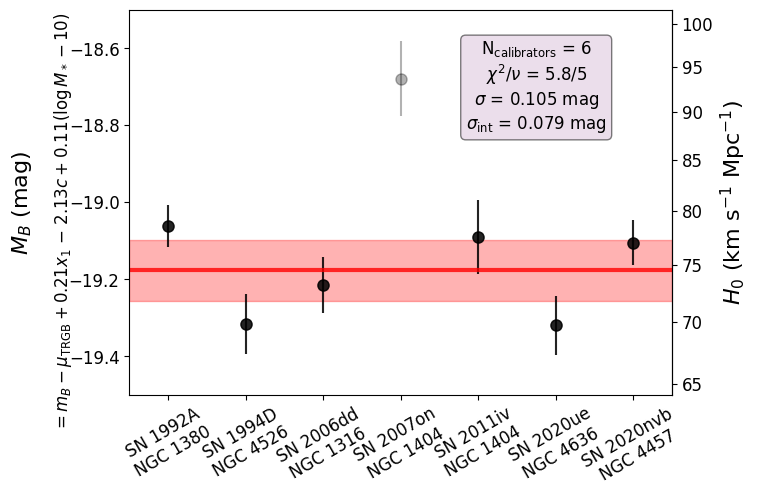

In [19]:
# plot calibrators

y = np.asarray(calib.cal_MB + alpha_mean*calib.x1 - beta_mean*calib.c + gamma_mean*(calib.log_hostmass - 10.0))
yerr = np.sqrt(np.asarray(calib.cal_MB_err**2 + (alpha_mean*calib.x1err)**2 
               + (beta_mean*calib.cerr)**2 
               + (gamma_mean*calib.log_hostmass_err)**2 
               + 2*alpha_mean*calib.cov_mb_x1
               - 2*beta_mean*calib.cov_mb_c
               - 2*alpha_mean*beta_mean*calib.cov_x1_c))
toterr = np.sqrt(yerr**2 + sigma_calib_mean**2)

residcalib = y - MB_mean
cchisq = np.sum((residcalib/toterr)**2)
sigcalib = np.std(residcalib)

# calibrator degrees of freedom = number of objects - 1; only M_B is fit from calibrators
ncdof = ncalib - 1

boxtext = "\n".join((r"N$_\mathrm{calibrators}$ = " + "{:d}".format(ncalib),
          r"$\chi^2/\nu$ = " + "{:.1f}".format(cchisq) + "/{:d}".format(ncdof),
          r"$\sigma$ = " + "{:.3f}".format(sigcalib) + " mag", 
          r"$\sigma_{\mathrm{int}}$ = " + "{:.3f}".format(sigma_calib_mean) + " mag"))
boxprops = dict(boxstyle='round', facecolor='thistle', alpha=0.5)

xx = np.arange(ncalib_all)
yy = np.asarray(calib_all.cal_MB + alpha_mean*calib_all.x1 - beta_mean*calib_all.c + gamma_mean*(calib_all.log_hostmass - 10.0))
yyerr = np.sqrt(np.asarray(calib_all.cal_MB_err**2 + (alpha_mean*calib_all.x1err)**2 
               + (beta_mean*calib_all.cerr)**2 
               + (gamma_mean*calib_all.log_hostmass_err)**2
               + 2*alpha_mean*calib_all.cov_mb_x1
               - 2*beta_mean*calib_all.cov_mb_c
               - 2*alpha_mean*beta_mean*calib_all.cov_x1_c))

x = xx[np.in1d(calib_all.SN,calib.SN)]

figcalib = plt.figure(figsize=(7,5))
plt.errorbar(xx,yy,yerr=yyerr,marker='o',linestyle='none',ms=8.,alpha=0.3, color='k')
plt.errorbar(x,y,yerr=yerr,marker='o',linestyle='none',ms=8.,alpha=0.8, color='k')
plt.xlim((-0.5,ncalib_all-0.5))
plt.ylim((-19.5,-18.5))
plt.fill_between(plt.xlim(),[0,0] + MB_mean - sigma_calib_mean, [0,0] + MB_mean + sigma_calib_mean, color='r', alpha=0.3)
plt.hlines(MB_mean,-1,ncalib_all,colors='r',alpha=0.8, lw=3)
plt.xticks(xx,calib_all.SN + '\n' + calib_all.host_name,rotation=30,fontsize=12)
plt.yticks(fontsize=12)
# plt.ylabel(r'$M_B = m_B - \mu_{\rm TRGB} + $' + 
#           f'{alpha_mean:.2f}$x_1$ $-$ {beta_mean:.2f}$c + {gamma_mean:.2f}(\log M_* - 10)$ (mag)',fontsize=10) 
plt.ylabel(r"$M_B$ (mag)", fontsize=16, labelpad=25)
plt.text(-1.5,-19.58,r'$= m_B - \mu_{\rm TRGB} + $' + 
         f'{alpha_mean:.2f}$x_1$ $-$ {beta_mean:.2f}$c + {gamma_mean:.2f}(\log M_* - 10)$', 
         fontsize=12,rotation='vertical')
plt.text(0.75, 0.8, boxtext, transform=plt.gca().transAxes, fontsize=12,
    verticalalignment='center', horizontalalignment='center', bbox=boxprops)
ax = plt.gca()
secax = ax.secondary_yaxis('right', functions=(MBtoH0, H0toMB))
secax.set_ylabel(r"$H_0$ (km s$^{-1}$ Mpc$^{-1}$)", fontsize=16)
secax.tick_params(labelsize=12)
plt.savefig(pdf_basename+"_calibrators.pdf",bbox_inches="tight")
plt.show()

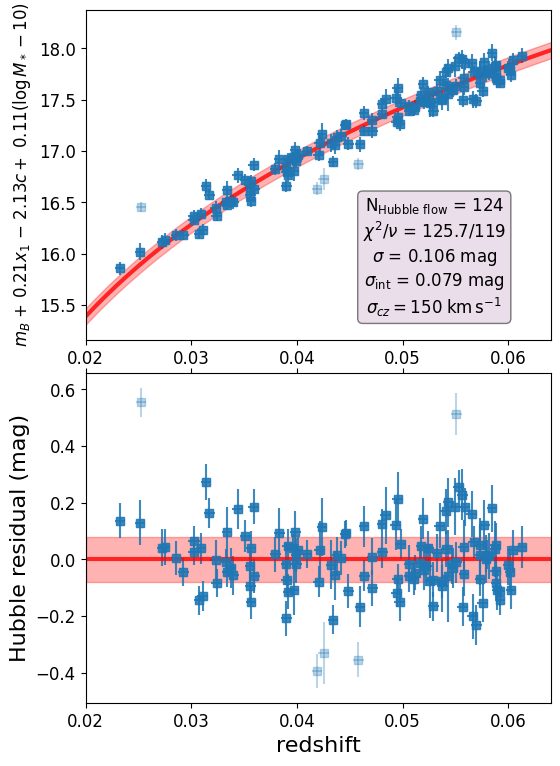

In [20]:
# plot Hubble flow
x = np.asarray(hflow.redshift_HD)
xerr = np.asarray(hflow.z_err)

y = np.asarray(hflow.mB + alpha_mean*hflow.x1 - beta_mean*hflow.c + gamma_mean*(hflow.globalmass - 10.0))
yerr = np.sqrt(np.asarray(hflow.mB_err**2 + (alpha_mean*hflow.x1_err)**2 
               + (beta_mean*hflow.c_err)**2 
               + (gamma_mean*hflow.globalmass_err)**2 
               + 2*alpha_mean*hflow.cov_mb_x1
               - 2*beta_mean*hflow.cov_mb_c
               - 2*alpha_mean*beta_mean*hflow.cov_x1_c))
toterr = np.sqrt(yerr**2 + sigma_hflow_mean**2)

modelm = np.asarray(MB_mean + distmod70(hflow.redshift_HD,mode=distmode) - 5.0 * np.log10(H0_mean/70.0))

hr = y - modelm
hpull = hr/toterr
hchisq = np.sum(hpull**2)
sighr = np.std(hr)

# Hubble flow degrees of freedom = number of objects - (ndim - 1); M_B is fit from calibrators
nhdof = nhflow - (ndim - 1)

boxtext = "\n".join((r"N$_\mathrm{Hubble\ flow}$ = " + "{:d}".format(nhflow),
          r"$\chi^2/\nu$ = " + "{:.1f}".format(hchisq) + "/{:d}".format(nhdof),
          r"$\sigma$ = " + "{:.3f}".format(sighr) + " mag", 
          r"$\sigma_{\mathrm{int}}$ = " + "{:.3f}".format(sigma_hflow_mean) + " mag",
          r"$\sigma_{cz} = " + "{:.0f}".format(pecvel_unc) + r"\;\mathrm{km\,s}^{-1}$"))
boxprops = dict(boxstyle='round', facecolor='thistle', alpha=0.5)
hxlabel = ("redshift") 

# outliers included version
xx = np.asarray(hflow_cut.redshift_HD)
xxerr = np.asarray(hflow_cut.z_err)
yy = np.asarray(hflow_cut.mB + alpha_mean*hflow_cut.x1 - beta_mean*hflow_cut.c + gamma_mean*(hflow_cut.globalmass - 10.0))
yyerr = np.sqrt(np.asarray(hflow_cut.mB_err**2 + (alpha_mean*hflow_cut.x1_err)**2
               + (beta_mean*hflow_cut.c_err)**2
               + (gamma_mean*hflow_cut.globalmass_err)**2
               + 2*alpha_mean*hflow_cut.cov_mb_x1
               - 2*beta_mean*hflow_cut.cov_mb_c
               - 2*alpha_mean*beta_mean*hflow_cut.cov_x1_c))
modelmm = np.asarray(MB_mean + distmod70(hflow_cut.redshift_HD,mode=distmode) - 5.0 * np.log10(H0_mean/70.0))
hrr = yy - modelmm


# plot Hubble diagram & residuals
fighflow = plt.figure(figsize=(6,9))
ax1 = plt.subplot(211)
ax1.errorbar(xx,yy,yerr=yyerr,xerr=xxerr,marker='s',linestyle='none',alpha=0.3,color='C0')
ax1.errorbar(x,y,yerr=yerr,xerr=xerr,marker='s',linestyle='none',alpha=0.8,color='C0')
plt.ylabel(r'$m_B$ + ' + f'{alpha_mean:.2f}$x_1$ $-$ {beta_mean:.2f}$c +$ {gamma_mean:.2f}$(\log M_* - 10)$',fontsize=12) 

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0.02,0.064)
ax1.set_xticks(np.arange(0.02,0.07,0.01))
zlim = plt.xlim()
zz = np.arange(zlim[0],zlim[1]+0.002,0.001)
dm = distmod70(zz,mode=distmode) - 5.0 * np.log10(H0_mean/70.0)
ax1.fill_between(zz,MB_mean + dm - sigma_hflow_mean,MB_mean + dm + sigma_hflow_mean,color='r',alpha=0.3)
ax1.plot(zz,MB_mean + dm,c='r',alpha=0.8, lw=3)
# place a text box in lower right in axes coords
ax1.text(0.75, 0.25, boxtext, transform=ax1.transAxes, fontsize=12,
    verticalalignment='center', horizontalalignment='center', bbox=boxprops)

ax2 = plt.subplot(212, sharex=ax1)
ax2.errorbar(xx,hrr,yerr=yyerr,xerr=xxerr,marker='s',linestyle='none',alpha=0.3,color='C0')
ax2.errorbar(x,hr,yerr=yerr,xerr=xerr,marker='s',linestyle='none',alpha=0.8,color='C0')
ax2.tick_params(axis="x", bottom=True, top=True)
plt.xlabel(hxlabel,fontsize=16)
plt.ylabel(r"Hubble residual (mag)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax2.fill_between(zlim,np.zeros(2) - sigma_hflow_mean, np.zeros(2) + sigma_hflow_mean, color='r', alpha=0.3)
ax2.plot(zlim,[0,0],c='r',alpha=0.8, lw=3)
plt.xlim(zlim)

plt.subplots_adjust(hspace=0.1)
plt.savefig(pdf_basename+"_hflow.pdf",bbox_inches="tight",dpi=600)
plt.show()

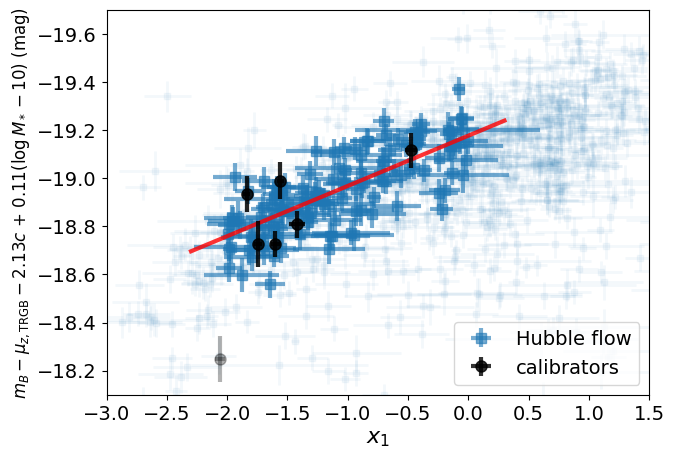

In [21]:
modelmu = distmod70(hflow.redshift_HD,mode=distmode) - 5.0 * np.log10(H0_mean/70.0)
modelmu_all = distmod70(hflow_all.redshift_HD,mode=distmode) - 5.0 * np.log10(H0_mean/70.0)

# x1 correction plot

# Hubble flow
x = np.asarray(hflow.x1)
xerr = np.asarray(hflow.x1_err)


y = np.asarray(hflow.mB - modelmu - beta_mean*hflow.c + gamma_mean*(hflow.globalmass - 10.0)) 
yerr = np.sqrt(np.asarray(hflow.mB_err**2  
               + (beta_mean*hflow.c_err)**2 
               + (gamma_mean*hflow.globalmass_err)**2 
               - 2*beta_mean*hflow.cov_mb_c))

# all objects version
xa = np.asarray(hflow_all.x1)
xaerr = np.asarray(hflow_all.x1_err)
ya = np.asarray(hflow_all.mB - modelmu_all - beta_mean*hflow_all.c + gamma_mean*(hflow_all.globalmass - 10.0))
yaerr = np.sqrt(np.asarray(hflow_all.mB_err**2
               + (beta_mean*hflow_all.c_err)**2 
               + (gamma_mean*hflow_all.globalmass_err)**2 
               - 2*beta_mean*hflow_all.cov_mb_c))

# best fit line
xx = np.linspace(x1_min-0.3,x1_max+0.3,101)
yy = MB_mean - alpha_mean*xx


# calibrators
cx = np.asarray(calib.x1)
cxerr = np.asarray(calib.x1err)
cy = np.asarray(calib.cal_MB - beta_mean*calib.c + gamma_mean*(calib.log_hostmass - 10.0))
cyerr = np.sqrt(np.asarray(calib.cal_MB_err**2 
               + (beta_mean*calib.cerr)**2 
               + (gamma_mean*calib.log_hostmass_err)**2
               - 2*beta_mean*calib.cov_mb_c))

cxx = np.asarray(calib_all.x1)
cxxerr = np.asarray(calib_all.x1err)
cyy = np.asarray(calib_all.cal_MB - beta_mean*calib_all.c + gamma_mean*(calib_all.log_hostmass - 10.0))
cyyerr = np.sqrt(np.asarray(calib_all.cal_MB_err**2 
               + (beta_mean*calib_all.cerr)**2 
               + (gamma_mean*calib_all.log_hostmass_err)**2 
               - 2*beta_mean*calib_all.cov_mb_c))

plt.figure(figsize=(7,5))
plt.plot(xx,yy,c='r',lw=3,zorder=7, alpha=0.8)
plt.errorbar(xa,ya,yerr=yaerr,xerr=xaerr,marker='s',ms=4,lw=2,linestyle='none',zorder=0,alpha=0.05,c='C0')
plt.errorbar(x,y,yerr=yerr,xerr=xerr,marker='s',ms=7,lw=3,linestyle='none',zorder=5,alpha=0.6,label='Hubble flow',c='C0')
plt.errorbar(cx,cy,yerr=cyerr,xerr=cxerr,marker='o',ms=8,lw=3,c='k',linestyle='none',zorder=10,alpha=0.8,label='calibrators')
plt.errorbar(cxx,cyy,yerr=cyyerr,xerr=cxxerr,marker='o',ms=8,lw=3,c='k',linestyle='none',zorder=9,alpha=0.3)
plt.gca().invert_yaxis()
plt.xlim((-3.0,1.5))
plt.ylim((-18.1,-19.7))
plt.xlabel(r'$x_1$', fontsize=16)
plt.ylabel(r'$m_B - \mu_{z,{\rm TRGB}} - $' + f'{beta_mean:.2f}$c$ + {gamma_mean:.2f}$(\log M_*-10)$ (mag)', fontsize=12) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right',fontsize=14)
plt.savefig(pdf_basename+"_x1.pdf",bbox_inches="tight")
plt.show()

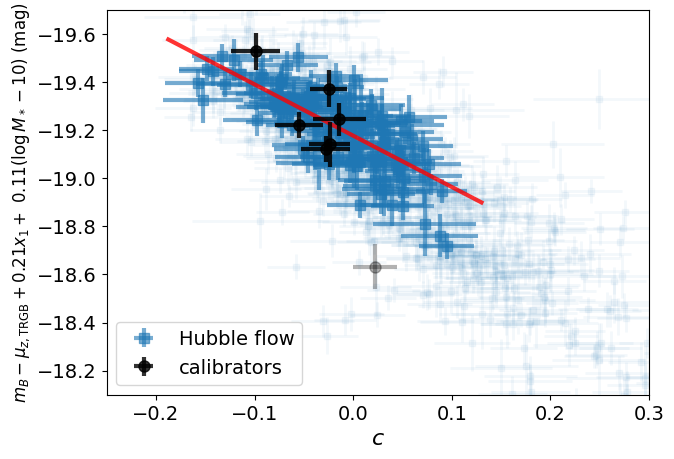

In [22]:
# c correction plot

# Hubble flow
x = np.asarray(hflow.c)
xerr = np.asarray(hflow.c_err)

y = np.asarray(hflow.mB - modelmu + alpha_mean*hflow.x1 + gamma_mean*(hflow.globalmass - 10.0)) 
yerr = np.sqrt(np.asarray(hflow.mB_err**2  
               + (alpha_mean*hflow.x1_err)**2 
               + (gamma_mean*hflow.globalmass_err)**2 
               + 2*alpha_mean*hflow.cov_mb_x1 ))

# best fit line
xx = np.linspace(np.min(x)-0.03,c_max+0.03,101)
yy = MB_mean + beta_mean*xx

# all objects version
xa = np.asarray(hflow_all.c)
xaerr = np.asarray(hflow_all.c_err)
ya = np.asarray(hflow_all.mB - modelmu_all + alpha_mean*hflow_all.x1 + gamma_mean*(hflow_all.globalmass - 10.0))
yaerr = np.sqrt(np.asarray(hflow_all.mB_err**2  
               + (alpha_mean*hflow_all.x1_err)**2 
               + (gamma_mean*hflow_all.globalmass_err)**2
               + 2*alpha_mean*hflow_all.cov_mb_x1 ))

# calibrators
cx = np.asarray(calib.c)
cxerr = np.asarray(calib.cerr)
cy = np.asarray(calib.cal_MB + alpha_mean*calib.x1 + gamma_mean*(calib.log_hostmass - 10.0))
cyerr = np.sqrt(np.asarray(calib.cal_MB_err**2 
               + (alpha_mean*calib.x1err)**2 
               + (gamma_mean*calib.log_hostmass_err)**2
               + 2*alpha_mean*calib.cov_mb_x1 ))

cxx = np.asarray(calib_all.c)
cxxerr = np.asarray(calib_all.cerr)
cyy = np.asarray(calib_all.cal_MB + alpha_mean*calib_all.x1 + gamma_mean*(calib_all.log_hostmass - 10.0))
cyyerr = np.sqrt(np.asarray(calib_all.cal_MB_err**2 
               + (alpha_mean*calib_all.x1err)**2 
               + (gamma_mean*calib_all.log_hostmass_err)**2 
               + 2*alpha_mean*calib_all.cov_mb_x1 ))

plt.figure(figsize=(7,5))
plt.plot(xx,yy,c='r',lw=3,zorder=7, alpha=0.8)
plt.errorbar(xa,ya,yerr=yaerr,xerr=xaerr,marker='s',ms=4,lw=2,linestyle='none',zorder=0,alpha=0.05,c='C0')
plt.errorbar(x,y,yerr=yerr,xerr=xerr,marker='s',ms=7,lw=3,linestyle='none',zorder=5,alpha=0.6,label='Hubble flow',c='C0')
plt.errorbar(cx,cy,yerr=cyerr,xerr=cxerr,marker='o',ms=8,lw=3,c='k',linestyle='none',zorder=10,alpha=0.8,label='calibrators')
plt.errorbar(cxx,cyy,yerr=cyyerr,xerr=cxxerr,marker='o',ms=8,lw=3,c='k',linestyle='none',zorder=9,alpha=0.3)
plt.gca().invert_yaxis()
plt.xlim((-0.25,0.30))
plt.ylim((-18.1,-19.7))
plt.xlabel(r'$c$',fontsize=16)
plt.ylabel(r'$m_B - \mu_{z,{\rm TRGB}} + $' + f'{alpha_mean:.2f}$x_1 +$ {gamma_mean:.2f}$(\log M_*-10)$ (mag)', fontsize=12) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower left',fontsize=14)
plt.savefig(pdf_basename+"_c.pdf",bbox_inches="tight")
plt.show()

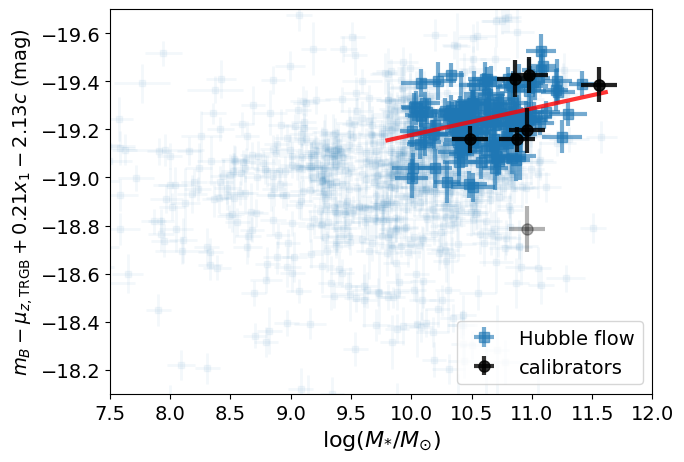

In [23]:
# hostmass correction plot

# Hubble flow
x = np.asarray(hflow.globalmass)
xerr = np.asarray(hflow.globalmass_err)

y = np.asarray(hflow.mB - modelmu + alpha_mean*hflow.x1 - beta_mean*hflow.c) 
yerr = np.sqrt(np.asarray(hflow.mB_err**2  
               + (alpha_mean*hflow.x1_err)**2 
               + (beta_mean*hflow.c_err)**2 
               + 2*alpha_mean*hflow.cov_mb_x1
               - 2*beta_mean*hflow.cov_mb_c
               - 2*alpha_mean*beta_mean*hflow.cov_x1_c))

# best fit line
xx = np.linspace(np.min(x)-0.2,np.max(x)+0.2,101)
yy = MB_mean - gamma_mean*(xx-10)

# all objects version
xa = np.asarray(hflow_all.globalmass)
xaerr = np.asarray(hflow_all.globalmass_err)
ya = np.asarray(hflow_all.mB - modelmu_all + alpha_mean*hflow_all.x1 - beta_mean*hflow_all.c)
yaerr = np.sqrt(np.asarray(hflow_all.mB_err**2
               + (alpha_mean*hflow_all.x1_err)**2 
               + (beta_mean*hflow_all.c_err)**2 
               + 2*alpha_mean*hflow_all.cov_mb_x1
               - 2*beta_mean*hflow_all.cov_mb_c
               - 2*alpha_mean*beta_mean*hflow_all.cov_x1_c))


# calibrators
cx = np.asarray(calib.log_hostmass)
cxerr = np.asarray(calib.log_hostmass_err)
cy = np.asarray(calib.cal_MB + alpha_mean*calib.x1 - beta_mean*calib.c)
cyerr = np.sqrt(np.asarray(calib.cal_MB_err**2 
               + (alpha_mean*calib.x1err)**2 
               + (beta_mean*calib.cerr)**2
               + 2*alpha_mean*calib.cov_mb_x1
               - 2*beta_mean*calib.cov_mb_c
               - 2*alpha_mean*beta_mean*calib.cov_x1_c))


cxx = np.asarray(calib_all.log_hostmass)
cxxerr = np.asarray(calib_all.log_hostmass_err)
cyy = np.asarray(calib_all.cal_MB + alpha_mean*calib_all.x1 - beta_mean*calib_all.c)
cyyerr = np.sqrt(np.asarray(calib_all.cal_MB_err**2 
               + (alpha_mean*calib_all.x1err)**2 
               + (beta_mean*calib_all.cerr)**2
               + 2*alpha_mean*calib_all.cov_mb_x1
               - 2*beta_mean*calib_all.cov_mb_c
               - 2*alpha_mean*beta_mean*calib_all.cov_x1_c))


plt.figure(figsize=(7,5))
plt.plot(xx,yy,c='r',lw=3,zorder=7, alpha=0.8)
plt.errorbar(xa,ya,yerr=yaerr,xerr=xaerr,marker='s',ms=4,lw=2,linestyle='none',zorder=0,alpha=0.05,c='C0')
plt.errorbar(x,y,yerr=yerr,xerr=xerr,marker='s',ms=7,lw=3,linestyle='none',zorder=5,alpha=0.6,label='Hubble flow',c='C0')
plt.errorbar(cx,cy,yerr=cyerr,xerr=cxerr,marker='o',ms=8,lw=3,c='k',linestyle='none',zorder=10,alpha=0.8,label='calibrators')
plt.errorbar(cxx,cyy,yerr=cyyerr,xerr=cxxerr,marker='o',ms=8,lw=3,c='k',linestyle='none',zorder=9,alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel(r'$\log (M_{*}/M_{\odot})$',fontsize=16)
plt.ylabel(r'$m_B - \mu_{z,{\rm TRGB}} + $' + f'{alpha_mean:.2f}$x_1 - ${beta_mean:.2f}$c$ (mag)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim((7.5,12.0))
plt.ylim((-18.1,-19.7)) 
plt.legend(loc='lower right',fontsize=14)
plt.savefig(pdf_basename+"_hostmass.pdf",bbox_inches="tight")
plt.show()

In [24]:
with open(pdf_basename+'_means.txt', 'w') as f:
    print("#  H0  +/-      M_B    +/-     -5a_B  +/-   sig_int +/-    alpha  +/-     beta  +/-    gamma  +/-", file=f)
    print(f" {means[0]:0.2f} {sigma[0]:0.2f}",end='',file=f)
    print(f"   {means[1]:0.3f} {sigma[1]:0.3f}",end='',file=f)
    print(f"   {means[2]:0.3f} {sigma[2]:0.3f}",end='',file=f)
    print(f"   {means[5]:0.3f} {sigma[5]:0.3f}",end='',file=f)
    print(f"   {means[3]:0.3f} {sigma[5]:0.3f}",end='',file=f)
    print(f"   {means[4]:0.3f} {sigma[4]:0.3f}",end='',file=f)
    if ndim >= 6:
        print(f"   {means[6]:0.3f} {sigma[6]:0.3f}",file=f)
    else:
        print(f"   0.000 0.000",file=f)

with open(pdf_basename+'_medians.txt', 'w') as f:
    print("# H0     +     -        M_B     +      -     -5a_B     +      -    sig_int   +      -     " + 
          "alpha    +      -     beta     +      -     gamma    +      -", file=f)
    print(f" {medians[0]:0.2f} {plus[0]:+0.2f} {minus[0]:0.2f}",end='',file=f)
    print(f"   {medians[1]:0.3f} {plus[1]:+0.3f} {minus[1]:0.3f}",end='',file=f)
    print(f"   {medians[2]:0.3f} {plus[2]:+0.3f} {minus[2]:0.3f}",end='',file=f)
    print(f"   {medians[5]:0.3f} {plus[5]:+0.3f} {minus[5]:0.3f}",end='',file=f)
    print(f"   {medians[3]:0.3f} {plus[3]:+0.3f} {minus[3]:0.3f}",end='',file=f)
    print(f"   {medians[4]:0.3f} {plus[4]:+0.3f} {minus[4]:0.3f}",end='',file=f)
    if ndim >= 6:
        print(f"   {medians[6]:0.3f} {plus[6]:+0.3f} {minus[6]:0.3f}",file=f)
    else:
        print(f"   0.000 +0.000 -0.000",file=f)


avpm = (plus-minus)/2.0
with open(pdf_basename+'_tab-results.tex', 'w') as f:
    print(f" {sample:<20} & ",end='',file=f)
    print(f"{ncalib:<1} & {sigcalib:0.3f} & ",end='',file=f)
    print(f"{nhflow:<3} & {sighr:0.3f} & ",end='',file=f)
    print(f"{medians[0]:0.1f} $\pm$ {avpm[0]:0.1f} $\pm$ {0.032*medians[0]:0.1f} & ",end='',file=f)
    print(f"${medians[1]:0.3f} \pm {avpm[1]:0.3f}$ & ",end='',file=f)
    print(f"${medians[2]:0.3f} \pm {avpm[2]:0.3f}$ & ",end='',file=f)
    print(f"${medians[5]:0.3f} \pm {avpm[5]:0.3f}$ & ",end='',file=f)
    print(f"${medians[3]:0.3f} \pm {avpm[3]:0.3f}$ & ",end='',file=f)
    print(f"${medians[4]:0.2f} \pm {avpm[4]:0.2f}$ & ",end='',file=f)
    if ndim >= 6:
        print(f"${medians[6]:0.3f} \pm {avpm[6]:0.3f}$ \\\\",file=f)
    else: 
        print(r" \nodata \\",file=f)